<a href="https://colab.research.google.com/github/praveenraghuvanshi/eva4-p2-group/blob/master/Session-2/Assignment-2/src/eva4p2s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment -2 MobileNet_V2 on Custom Dataset

### Team Members
- Praveen Raghuvanshi (praveenraghuvanshi@gmail.com)
- Tusharkanta Biswal (Tusharkanta_biswal@stragure.com)
- Suman Kanukollu (sumankanukollu@gmail.com)
- Shubham Kothawade (kothawadeshub@gmail.com)


Tasks
-----
1. Load images into dataloader from zip file
2. Resize image if required to 224x224x3
3. Split dataset
4. Load Mobilenet_V2 model with pretrained=false
5. Train model
6. Save model
7. Use new model in serverless.yml
8. Deploy to AWS
9. Test with rest client
10. Done :-)

In [1]:
# CUDA_LAUNCH_BLOCKING="1"

In [2]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=59ab2c5dbbe8601345a5955c6f3b1cbe21aac44dd5d6bb43fde07583a5e61067
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
!nvidia-smi

Sat Jul 25 14:20:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)
time: 3.11 s


## Mount google drive


In [5]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 22.6 s


In [6]:
%cd "/content/drive/My Drive/eva-4/Phase-2/Session-2/ds"
!ls

/content/drive/My Drive/eva-4/Phase-2/Session-2/ds
'Flying Birds'	'Large QuadCopters'  'Small QuadCopters'  'Winged Drones'
time: 3.53 s


### Application Constants

In [7]:
classes =  [ 'Flying Birds', 'Large QuadCopters', 'Small QuadCopters','Winged Drones' ]
dataFolder = '/content/drive/My Drive/eva-4/Phase-2/Session-2/ds'
zipFilePath = '/content/drive/My Drive/eva-4/Phase-2/Session-2'

time: 4.72 ms


### Utility Functions

In [8]:
import os.path
from os import path

def createDirectories():
  treedirectories = [
               '/content/drive/My Drive/eva-4',
               '/content/drive/My Drive/eva-4/Phase-2',
               '/content/drive/My Drive/eva-4/Phase-2/Session-2',
               '/content/drive/My Drive/eva-4/Phase-2/Session-2/ds'
               ]

  for directory in treedirectories:
    if os.path.exists(directory) is False:
      os.mkdir(directory)
      print(directory)

time: 6.99 ms


In [20]:
import shutil

def removeExtraDirectories():
  # Remove extra directory
  for subDirectory in os.listdir(dataFolder):
    if subDirectory not in classes:
      shutil.rmtree(dataFolder + '/' + subDirectory)
      print(subDirectory)

time: 2.75 ms


In [10]:
from zipfile import ZipFile

def extract_images(zipfilename, targetfolder):
  
  zipObj = ZipFile(zipfilename, 'r')
  #print("zipObj " +zipObj)
  zipObj.extractall(targetfolder)
  zipObj.close()

time: 3.76 ms


In [11]:
def extractClassImages():
  for cls in classes:
    classPath = dataFolder + '/' + cls
    if os.path.exists(classPath) is False:
      zipFile = zipFilePath + '/' + cls + '.zip'
      extract_images(zipFile, dataFolder)
      print(len(os.listdir(classPath)))

time: 5.81 ms


In [21]:
createDirectories()
removeExtraDirectories()
extractClassImages()

.ipynb_checkpoints
time: 12.1 ms


In [22]:
!ls

'Flying Birds'	'Large QuadCopters'  'Small QuadCopters'  'Winged Drones'
time: 2.71 s


## Read Dataset

In [23]:
import torchvision.transforms as transforms
transform = {
        'train': transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ]),
        'test': transforms.Compose([
            transforms.Resize([224,224]),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])
    }

time: 5.27 ms


## DataLoader

In [17]:
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
def load_data(imageFolder):
  dataset = torchvision.datasets.ImageFolder(imageFolder,transform=transform['train'])
  print(dataset.classes)

  # print(dataset.targets)
  def get_subset(indices, start, end):
      return indices[start : start + end]

  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  TRAIN_PCT, TEST_PCT = 0.7, 0.3  
  train_count = int(len(dataset) * TRAIN_PCT)
  test_count = int(len(dataset) * TEST_PCT)

  indices = torch.randperm(len(dataset))


  train_idx = get_subset(indices, 0, train_count)
  print(len(train_idx))
  test_idx = get_subset(indices, train_count, len(dataset))
  trainloader=torch.utils.data.DataLoader(dataset,batch_size=32,num_workers=4, pin_memory=True,sampler=SubsetRandomSampler(train_idx))
  testloader=  torch.utils.data.DataLoader(dataset,batch_size=32,num_workers=4, pin_memory=True,sampler=SubsetRandomSampler(test_idx))
  return trainloader, testloader, dataset

time: 20.2 ms


In [24]:
train_loader, val_loader, dataset=load_data('/content/drive/My Drive/eva-4/Phase-2/Session-2/ds')

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
CUDA Available? True
13296
time: 280 ms


## Display Images

In [25]:
import torchvision
from matplotlib import pyplot as plt

def show(imgs,lbls=None, figsize=(100,100), *args, **kwargs):
    grid_tensor = torchvision.utils.make_grid(imgs[:8], *args, **kwargs)
    grid_image = grid_tensor.permute(1,2,0)
    plt.figtext(100,100,'Images')
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if lbls is not None:
        print(' '.join('%22s' % [lbls[j]] for j in range(10)))
    plt.close()

time: 6.35 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

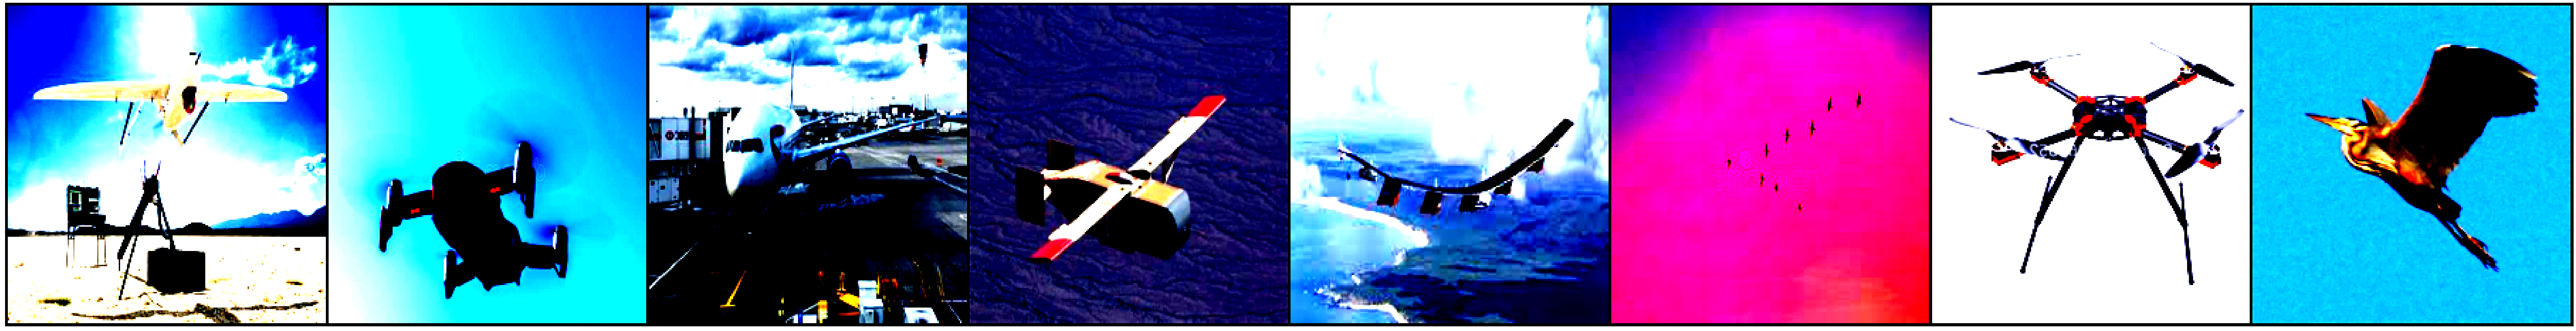

           [tensor(3)]            [tensor(2)]            [tensor(3)]            [tensor(3)]            [tensor(3)]            [tensor(0)]            [tensor(1)]            [tensor(0)]            [tensor(0)]            [tensor(3)]
time: 13.3 s


In [26]:
import numpy as np
image, label = next(iter(train_loader))
show(image,label)

## Load model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=False)
model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 3.04 s


#### Freeze and modify final layer

In [28]:
for param in model.parameters():
    param.requires_grad = False    

n_inputs = model.classifier[1].in_features

model.classifier = torch.nn.Sequential(torch.nn.Linear(n_inputs, 512),
                            # torch.nn.ReLU6(),
                            # torch.nn.Dropout(0.2),
                            torch.nn.Linear(512, 4),
                            torch.nn.LogSoftmax(dim=1))

time: 17.8 ms


In [29]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 14.4 ms


### Define loss function and optimizer

In [30]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.01
momentum = 0.9
step_size = 2
gamma = 0.96

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=momentum,
    nesterov=True) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1,
    verbose=False, 
    threshold=0.0001,
    threshold_mode='abs',
    cooldown=0, 
    min_lr=1e-8,
    eps=1e-08
)


time: 8.57 ms


In [31]:
class EarlyStoppingOnAcc:
    def __init__(self, patience=7, mode="max", delta=0.0001, model_path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
            traced_model = torch.jit.trace(model.float(), torch.randn(1,3,224,224).to(device))
            torch.jit.save(traced_model, 'modelnet_v2_44_77.pt')
            # traced_model.save('modelnet_v2_44_77.pt')
            torch.save(model, 'model.pt')
        self.val_score = epoch_score

time: 35.3 ms


## Train Model

In [32]:
from torch.autograd import Variable

def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    early_stopping = EarlyStoppingOnAcc(patience=patience)
    
    for epoch in range(1, n_epochs + 1):
        for param_group in optimizer.param_groups:
          lr = param_group["lr"]
          print(f'\n **** learning rate: {lr}')
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            
            # loss = Variable(loss, requires_grad = True)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        correct = 0
        total = 0
        accuracy = 0
        for inputs, target in val_loader:
            inputs, target = inputs.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        valid_accuracy = 100 * correct / total

        epoch_len = len(str(n_epochs))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'\tvalid_loss: {valid_loss:.5f}' +
                     f'\tvalid_accuracy: {valid_accuracy:.2f}')
        
        print(print_msg)

        # Tensorboard logging
        '''tb.add_scalar('Loss - Train loss',
                            train_loss / len(train_loader),
                            epoch * len(train_loader))
            
        tb.add_scalar('Loss - Val',
                        valid_loss/len(val_loader),
                        epoch * len(val_loader))
        
        tb.add_scalar('Accuracy - Val',
                            valid_accuracy/len(val_loader),
                            epoch * len(val_loader))'''
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        valid_accuracy = round(valid_accuracy, 2)
        scheduler.step(valid_accuracy)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        model_path = 'checkpoint.pt' # f'jantahackathon_v13_{valid_accuracy}.pth'
        early_stopping(valid_accuracy, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            if early_stopping.best_score is not None:
              print(f'Best score: {early_stopping.best_score}')
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    return  model, avg_train_losses, avg_valid_losses

time: 97.1 ms


In [ ]:
batch_size = 512
n_epochs = 30

# train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)


 **** learning rate: 0.01


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  


[ 1/30] train_loss: 1.34048 	valid_loss: 1.32358	valid_accuracy: 36.69
Validation score improved (-inf --> 36.69). Saving model!

 **** learning rate: 0.01


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expe


[ 2/30] train_loss: 1.32533 	valid_loss: 1.31239	valid_accuracy: 37.37
Validation score improved (36.69 --> 37.37). Saving model!

 **** learning rate: 0.01


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


## Visualizing the loss

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Load the saved model

In [ ]:
!ls

In [ ]:
loadedModel = torch.jit.load('modelnet_v2_44_77.pt')
print(loadedModel)

In [ ]:
model=torch.load('./model.pt')
model.eval()

In [ ]:
from torchvision import transforms
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:

from torch.autograd import Variable

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = image
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    '''data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)'''
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    return images, labels

## Validate Model

In [ ]:

from matplotlib import pyplot as plt

to_pil = torchvision.transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(70,70))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    #print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    if res:
        sub.set_title(index)
    else:
        print('Misclassified Image :\n\tActual Label : {} and predicted : {}'.format(int(labels[ii]),index))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Test model

In [ ]:
from matplotlib import pyplot as plt
predClass = []

#for _ in np.arange(float(len(testDs))/8.0+1): 
data = iter(val_loader)
#for v in np.arange(float(len(testDs))/8.0+1): 
from IPython.core.debugger import set_trace
res = True
row = 1
while res:
    try:
        images = data.next()
        res = False if len(images)==0 else True
    except Exception as e:
        print(str(e))
        break
    to_pil = torchvision.transforms.ToPILImage()

    print(f'Row : {row}')
    row = row + 1
    #fig=plt.figure(figsize=(30,30))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        predClass.append(index)
        #sub = fig.add_subplot(1, len(images), ii+1)
        #sub.set_title(index)
        #plt.axis('off')
        #plt.imshow(image)
    #plt.show()
    #set_trace()

In [ ]:
print(len(np.array(predClass)))

## Setup in powershell

1. Start powershell in admin mode
2. Set execution policy 'Set-ExecutionPolicy Scope Process -ExecutionPolicy Bypass'
3.serverless plugin install serverless-python-requirements
4. npm run deploy
5. Grant permission to docker for file sharing
